In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8f2015a2921a6b0bdd1d0d05828ceef25953122b076ac8099dfbad59f6524e34
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Câu 2

In [ ]:
from pyspark.sql import SparkSession
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np

class CIFAR10SVDReducer:
    def __init__(self, k=64):
        self.spark = SparkSession.builder.appName("SVD CIFAR-10").getOrCreate()
        self.k = k

    def load_data(self, file_path):
        df = self.spark.read.csv(file_path, header=False, inferSchema=True)
        return df

    @staticmethod
    def _convert_to_vector(row):
        label = row[0]
        features = Vectors.dense(row[1:])
        return (label, features)

    def reduce_dimensions(self, df):
        rows_rdd = df.rdd.map(self._convert_to_vector)
        labels, features = zip(*rows_rdd.collect())
        mat = RowMatrix(self.spark.sparkContext.parallelize(features))

        svd = mat.computeSVD(self.k, computeU=True)
        transformed_features = np.array(svd.U.rows.collect())
        return labels, transformed_features

    @staticmethod
    def save_results(file_path, labels, features):
        np.savetxt(file_path, np.column_stack((labels, features)), delimiter=",")

reducer = CIFAR10SVDReducer(k=64)

train_df = reducer.load_data("cifar10-test-1k.csv")
train_labels, train_features = reducer.reduce_dimensions(train_df)

reducer.save_results("cifar10-test-svd.csv", train_labels, train_features)


# Cau 3

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

class RatingPredictor:
    def __init__(self, data_path):
        self.spark = SparkSession.builder.appName("RatingPredictor").getOrCreate()
        self.data = self.spark.read.csv(data_path, header=True, inferSchema=True)
        self.model = self.train_model()

    def train_model(self):
        als = ALS(userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop")
        model = als.fit(self.data)
        return model

    def predict_rating(self, userId, itemId, N):
        if self.data.filter((col("user") == userId) & (col("item") == itemId)).count() > 0:
            return self.data.filter((col("user") == userId) & (col("item") == itemId)).first().rating
        elif self.data.filter(col("user") == userId).count() > 0 and self.data.filter(col("item") == itemId).count() > 0:
            user_df = self.spark.createDataFrame([(userId, itemId)], ["user", "item"])
            predictions = self.model.transform(user_df)
            return predictions.first().prediction
        else:
            return -1

predictor = RatingPredictor("ratings2k.csv")
rating = predictor.predict_rating(userId=73, itemId=52, N=10)
print(rating)

4.0


# Câu 5

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

class DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data_frame = self.load_data()

    def load_data(self):
        spark = SparkSession.builder.appName("CIFAR10Classifier").getOrCreate()
        df = spark.read.csv(self.file_path, header=False, inferSchema=True)
        assembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")
        return assembler.transform(df).select("_c0", "features").withColumnRenamed("_c0", "label")


In [ ]:
class BaseModel:
    def __init__(self, model):
        self.model = model
        self.trained_model = None

    def train(self, train_df):
        self.trained_model = self.model.fit(train_df)

    def evaluate(self, test_df):
        evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
        predictions = self.trained_model.transform(test_df)
        return evaluator.evaluate(predictions)

class MLPModel(BaseModel):
    def __init__(self, layers):
        model = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234)
        super().__init__(model)

class RandomForestModel(BaseModel):
    def __init__(self, numTrees):
        model = RandomForestClassifier(numTrees=numTrees)
        super().__init__(model)

from pyspark.ml.classification import OneVsRest

class SVMModel(BaseModel):
    def __init__(self, maxIter, regParam):
        svm = LinearSVC(maxIter=maxIter, regParam=regParam)
        model = OneVsRest(classifier=svm)
        super().__init__(model)


In [ ]:
class CIFAR10Classifier:
    def __init__(self):
        self.models = {
            "MLP": MLPModel(layers=[1024, 512, 256, 10]),
            "Random Forest": RandomForestModel(numTrees=10),
            "SVM": SVMModel(maxIter=10, regParam=0.1)
        }

    def run(self, train_data, test_data, k=None):
        results = {}
        if k != None:
            self.models["MLP"] =  MLPModel(layers=[k, 512, 256, 10])
        for name, model in self.models.items():
            model.train(train_data)
            accuracy_train = model.evaluate(train_data)
            accuracy_test = model.evaluate(test_data)
            results[name] = (accuracy_train, accuracy_test)
        return results

    def plot_results(self, results, results_svd):
        import numpy as np
        import matplotlib.pyplot as plt

        # Chuẩn bị dữ liệu cho biểu đồ
        models = list(results.keys())
        accuracies_train = [results[m][0] for m in models]
        accuracies_test = [results[m][1] for m in models]
        accuracies_train_svd = [results_svd[m][0] for m in models]
        accuracies_test_svd = [results_svd[m][1] for m in models]

        x = np.arange(len(models))  # vị trí label trên trục x
        width = 0.2  # độ rộng của cột

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - 1.5*width, accuracies_train, width, label='Train')
        rects2 = ax.bar(x - 0.5*width, accuracies_test, width, label='Test')
        rects3 = ax.bar(x + 0.5*width, accuracies_train_svd, width, label='Train-SVD')
        rects4 = ax.bar(x + 1.5*width, accuracies_test_svd, width, label='Test-SVD')

        # Thêm labels và title
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy by Model and Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()

        # Hiển thị biểu đồ
        plt.show()


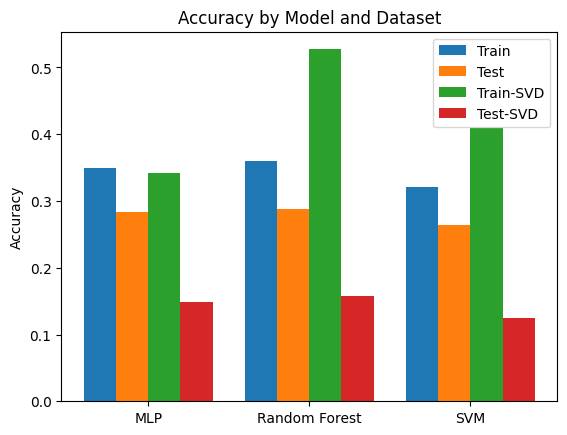

In [ ]:
# Khởi tạo và xử lý dữ liệu
train_processor = DataProcessor("cifar10-train-5k.csv")
test_processor = DataProcessor("cifar10-test-1k.csv")
train_svd_processor = DataProcessor("cifar10-train-svd.csv")
test_svd_processor = DataProcessor("cifar10-test-svd.csv")

# Khởi tạo và chạy classifier
classifier = CIFAR10Classifier()
results = classifier.run(train_processor.data_frame, test_processor.data_frame)
results_svd = classifier.run(train_svd_processor.data_frame, test_svd_processor.data_frame, k = 64)

# Vẽ biểu đồ
classifier.plot_results(results, results_svd)